<a href="https://colab.research.google.com/github/fpinell/hands_on_python_for_ds/blob/main/notebooks/phd/Hands_On_Lab_PhD_CNN_Bicycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bicycle Images Category Classification using CNN

In the course final project we will download about 300 pictures, train the net and try to classify the bicycle type by its type: 

1.   Gravel / Adventure / Bikepacking 
2.   Road
3.   Mountain

The project outline will be dividied according to the following


1.   Dataset description and pre processing
2.   Model Description and Construction
3.   Model training and evaluation via ad-hoc custom functions
4.   Model performance on random test sample 
5.   Explainable AI: CNN prediction interpretability via LIME




We first load the needed modules from PyTorch 

In [1]:
import torch
import os 
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision.utils import make_grid #useful to show a batch of pictures

!pip install torchinfo #this is a very useful library to show and double check the CNN correct sizing
from torchinfo import summary

import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Dataset Description and PreProcessing

I kept the picture dataset in my Google Drive and with **drive.mount**  mount the remote drive in the Colab session    

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


I divided the dataset folder in two sudirectories: test and train. Furthermore, I created 3 different folders and in each i have put picture relative to the specific bicycle type: road, mountain and gravel. Torchvision **ImageFolder** really helps with dataset creation by assigning a label equal to the subdirectory name

In [5]:

#train and test data directory

data_dir = '/content/drive/MyDrive/data (1)/train/'
test_data_dir = '/content/drive/MyDrive/data (1)/test'





Here I do a quick check to mkae sure the directory loaded correctly

In [6]:
gravel_bikes = os.listdir(data_dir + '/gravel_bikes')
print(f"Number of Bikes : {len(gravel_bikes)}")
print(gravel_bikes[45:50])

Number of Bikes : 95
['gravel_bike_46.jpg', 'gravel_bike_47.png', 'gravel_bike_48.jpg', 'gravel_bike_49.jpg', 'gravel_bike_50.jpg']


This is another great feature of TorchVision. Here I can "compose" the sequence of preprocessing tasks I want to apply to the picture. In this case I resize them and cast them to a Tensor

In [7]:
transform = tt.Compose([
    tt.ToTensor(),
    tt.Resize((150, 150))
])

In [8]:
train_ds = ImageFolder(data_dir, transform=transform)
test_ds = ImageFolder(test_data_dir, transform=transform)

This is the output of the output of the ImageFolder class. For each sample inside the training set I get the image as well as the target label. In our case we have a color image (rgb, 3 channels) 150x150

In [9]:
img, label = train_ds[0]
print(img.shape,label)


torch.Size([3, 150, 150]) 0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Here I check that the target/labels are correctly named:

In [10]:
classes = train_ds.classes
print("The bike catgeories are: \n",classes)

The bike catgeories are: 
 ['gravel_bikes', 'mountain_bikes', 'road_bikes']


torch.utils.data.Dataset is an abstract class representing a dataset. I can also create a custom dataset should inherit Dataset and override the following methods:

__len__ so that len(dataset) returns the size of the dataset.
__getitem__ to support the indexing such that dataset[i] can be used to get i ith sample.

In [11]:
print(f"Images in training data : {len(train_ds)}")
print(f"Images in test data : {len(test_ds)}")

Images in training data : 287
Images in test data : 29


Whenever I want to exhibit an image stored as tensor i have to permute the column order:

In [12]:
def display_img(img,label):
    print(f"Label : {train_ds.classes[label]}")
    plt.imshow(img.permute(1,2,0))

Label : gravel_bikes


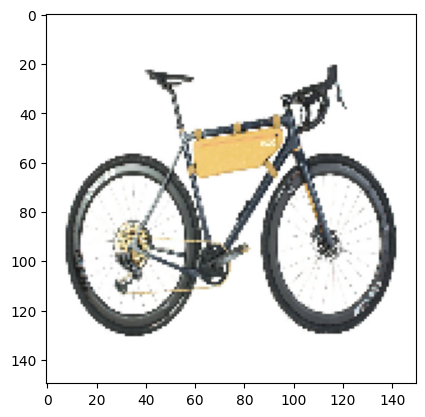

In [13]:
display_img(*train_ds[67])

Here I randomly shuffle the train dataset and I create a validation set with 70 images.

In [14]:
random_seed = 2021
torch.manual_seed(random_seed)
val_size = 70
train_size = len(train_ds) - val_size 

train_data,val_data = random_split(train_ds,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")
print(f"Length of Test Data : {len(test_ds)}")

Length of Train Data : 217
Length of Validation Data : 70
Length of Test Data : 29


torch.utils.data.**DataLoader** is an iterator which provides these features:

* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.

I choose a batch of size 10 with the exception of the test set where I choose the size equal to the test set length.


In [15]:
train_dl = DataLoader(train_data, batch_size=10, shuffle=True, pin_memory=True, num_workers=2)
val_dl = DataLoader(val_data, batch_size=10, shuffle=True, pin_memory=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=29, shuffle=False, pin_memory=True, num_workers=2)

In [16]:
print(f'The size of the training dataset is:{len(train_dl.dataset)} whereas the number of the batch trains is:{len(train_dl)}')

The size of the training dataset is:217 whereas the number of the batch trains is:22


Here I use **make_grid** from TorchVision in order to show the images of the Test Dataset

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (10,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=5).permute(1,2,0))
        break

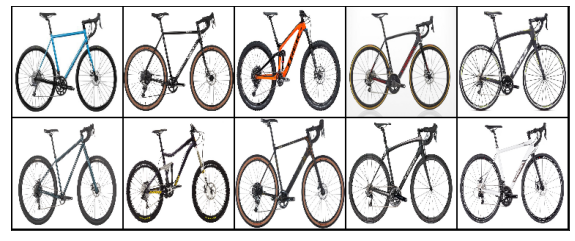

In [ ]:
show_batch(val_dl)

Here I extend the Torch.nn.Module class and design the CNN. The architecture of the CNN is borrowed from the Intel Image Classification Competition which was a 2019 hackathon whole goal was oriented toward a multi-class classification situation to predict one of several (more than two) possible outcomes.

## 2. Model Description and Construction

In [17]:
class BicycleImageClassfierCNN(nn.Module):
    def __init__(self):
        super(BicycleImageClassfierCNN,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,3)
        )
    
    def forward(self, image):
        output = self.model(image)
        return output

In [18]:
model = BicycleImageClassfierCNN()
model

BicycleImageClassfierCNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear

Unlike Keras, PyTorch does not natively support a quick summary of layers' size and weight matrix shape. Fortunately we can use TorchInfo module and the summary method to compute a net description.

I learnt the hard way that a summary is not enough! Especially when flattening the CNN after pooling and convolutions it is important to understand the tensor shape dimensions. This is a useful formula:

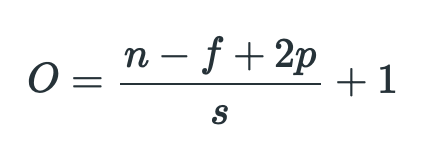

For example we can see that the 1st convolution layer still has 150x150 shape (150-3+2)+1=150. This is why a padding of 1 is usually added.

It is also crucial to keep in mind that pooling (avg or max) has a huge impact on the resulting tensor size. The formula is:

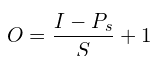

In our case the 150x150 tensor shape is halved (1/2)*(150-2)+1=75

The passage from the CNN to the Fully Connected layer requires the weight matrix to flatten and it is also crucial to do the cals right. In our case 256x18x18=82944.

Last I want to mention one thing related to the weight matrix shape which can be computed via the following:

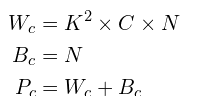

For example in the first CONV layes we have K=3, C=3 and N=32 ==> 896 (including 32 biases) parameters.

In [19]:

batch_size = 10
summary(model, input_size=(batch_size, 3, 150, 150))


Layer (type:depth-idx)                   Output Shape              Param #
BicycleImageClassfierCNN                 [10, 3]                   --
├─Sequential: 1-1                        [10, 3]                   --
│    └─Conv2d: 2-1                       [10, 32, 150, 150]        896
│    └─ReLU: 2-2                         [10, 32, 150, 150]        --
│    └─Conv2d: 2-3                       [10, 64, 150, 150]        18,496
│    └─ReLU: 2-4                         [10, 64, 150, 150]        --
│    └─MaxPool2d: 2-5                    [10, 64, 75, 75]          --
│    └─Conv2d: 2-6                       [10, 128, 75, 75]         73,856
│    └─ReLU: 2-7                         [10, 128, 75, 75]         --
│    └─Conv2d: 2-8                       [10, 128, 75, 75]         147,584
│    └─ReLU: 2-9                         [10, 128, 75, 75]         --
│    └─MaxPool2d: 2-10                   [10, 128, 37, 37]         --
│    └─Conv2d: 2-11                      [10, 256, 37, 37]         295,

## 3. Model training and evaluation via ad-hoc custom functions

This is where I define the function used to train the net and compute performance metrics on the validation set.

In [20]:
def my_train(model, optimizer, loss_fn, train_loader, val_loader, epochs=3,to_print=False):
    history = []
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad() # clear gradients for next train
            inputs, targets = batch
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward() # backpropagation, compute gradients
            optimizer.step() # apply gradients
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_data)
        
        with torch.no_grad():
          model.eval()
          correct = 0
          total = 0
          for batch in val_loader:
              inputs, targets = batch
              output = model(inputs)
              loss = loss_fn(output,targets) 
              valid_loss += loss.data.item() * inputs.size(0)
              _, predicted = torch.max(output.data, 1)
              total += targets.size(0)
              correct += (predicted == targets).sum().item()

          valid_loss /= len(val_data)
          accy=correct / total

        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, accuracy = {:.4f}'.format(epoch, training_loss,
        valid_loss, accy))
        history.append({"loss": training_loss, 
                        "val_loss": valid_loss, 
                        "val_acc": accy
                       })
    return history

In [21]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)

    def __len__(self):
        """ Number of batches """
        return len(self.dl)

    

In [22]:
device='cuda'
model = model.to(device)
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [23]:
len(train_dl)

22

In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 6

#history = fit(train_dl, val_dl, epochs, optimizer, loss_fn, model)
history=my_train(model, optimizer,loss_fn, train_dl,val_dl, epochs)

Epoch: 1, Training Loss: 1.1037, Validation Loss: 1.0966, accuracy = 0.3571
Epoch: 2, Training Loss: 1.0775, Validation Loss: 0.9222, accuracy = 0.7714
Epoch: 3, Training Loss: 0.5827, Validation Loss: 0.4737, accuracy = 0.8143
Epoch: 4, Training Loss: 0.3152, Validation Loss: 0.1984, accuracy = 0.9286
Epoch: 5, Training Loss: 0.1672, Validation Loss: 0.2395, accuracy = 0.9000
Epoch: 6, Training Loss: 0.1599, Validation Loss: 0.4019, accuracy = 0.9143


In [34]:
train_loss = [x['loss'] for x in history]
val_loss = [x['val_loss'] for x in history]
val_acc = [x['val_acc'] for x in history]

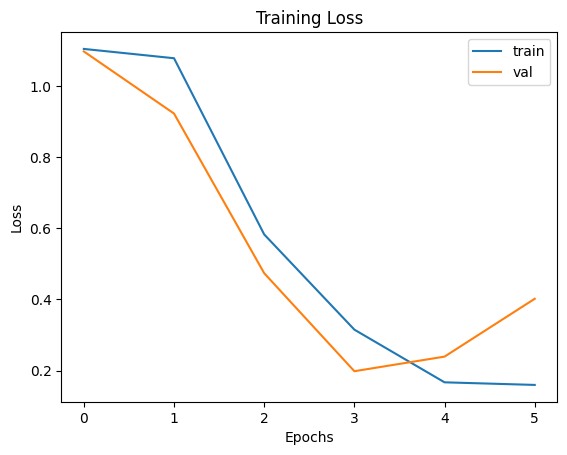

In [35]:
epoch = np.arange(epochs)
plt.plot(epoch, train_loss)
plt.plot(epoch, val_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend(['train', 'val']);

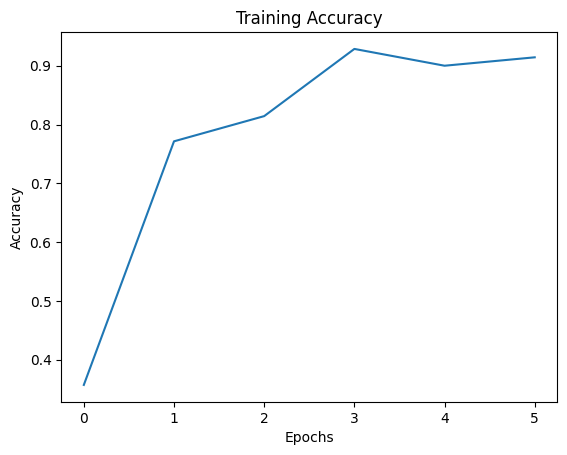

In [36]:
epoch = np.arange(6)
plt.plot(epoch, val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy');

In [37]:
preds = []
with torch.no_grad():
  for img,label in test_dl:
      out = model(img)
      _, pred = torch.max(out, dim=1)
      preds.append(pred.to('cpu').numpy())
      break

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [38]:
classes_pred = [classes[x] for x in preds[0]] 

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


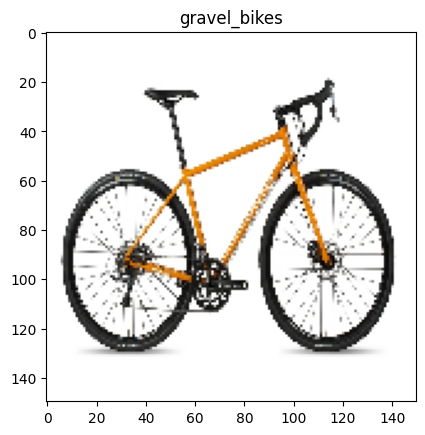

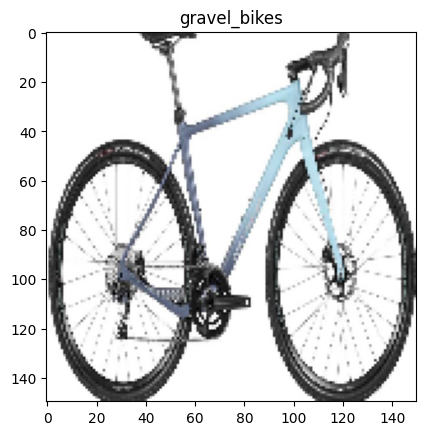

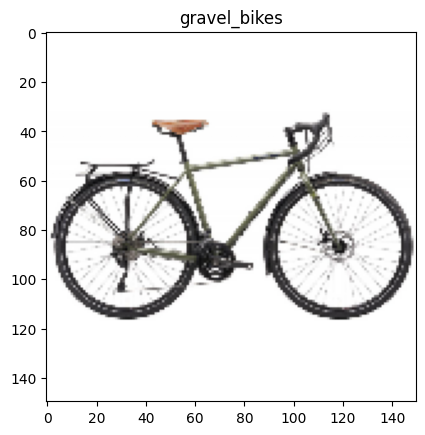

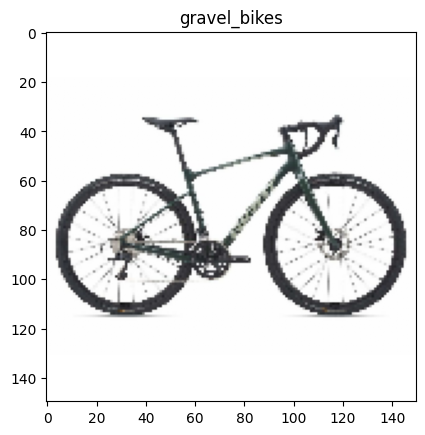

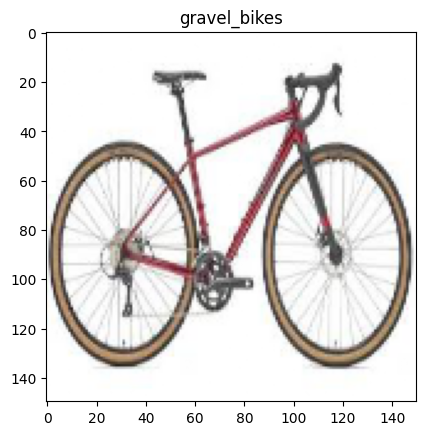

In [39]:
for img,label in test_dl:
    for i in range(5):
        plt.imshow(img[i].to('cpu').permute(1, 2, 0))
        plt.title(classes_pred[i])
        plt.show()
    break

In [40]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Accuracy of the network on the test images: 82 %


# Lime

Initially I was planning to repeat the same analysis above using Keras and Tensorflow. However that seemed pretty straightforward (Keras makes traning a CNN even easier than PyTorch) and I decided to get my hands dirty with a little XAI project: try to understand and explain **why** the net has output a particular prediction. **SHAP** is almost natively integrated with PyTorch via Captum; **LIME is not**. Therefore I thought this would be a good idea to end the project. 

The vast majority of LIME implementations have been carried forward using Tensorflow..PyTorch so far had limited usage hence the steps are little bit more cumbersome. Luckily Marco Ribeiro, one of the LIME original paper authors, have published examples on how to use LIME with pretrained CNN. I took inspiration from his work and tried to extend it his example on custom CNN as the one I designed in the previous sections...

We first install and import the required libraries

In [32]:
!pip install lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=29b81ef5af557bb00ebcc8beba5d7c2c92c65ac33aa6557687484012a757ff3f
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


Then we choose a random picture from the Gravel Bike folder

In [42]:
path=data_dir + 'gravel_bikes/gravel_bike_64.jpg'
path

'/content/drive/MyDrive/data (1)/train/gravel_bikes/gravel_bike_64.jpg'

Now we visualize the image

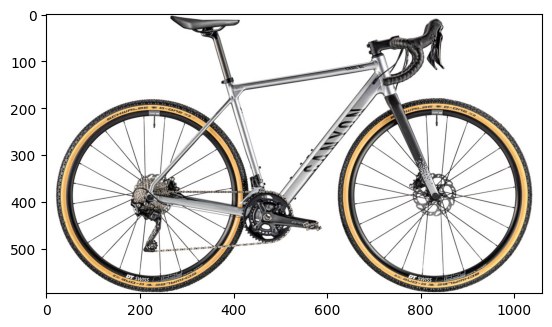

In [43]:
from PIL import Image
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image(path)
plt.imshow(img)


In this section we manually pre-process the image to tensor and resize it and feed it to our trained CNN

In [45]:
from torchvision import  transforms
# resize and take the center part of image to what our model expects
def get_input_transform():
         
    transf = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor()
       
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    #return transf(img)
    return transf(img).unsqueeze(0)

For some reason I found easier to work with CPU when using LIME...thus I am moving the model storage to CPU

In [46]:
img_t = get_input_tensors(img)
img_t.shape
device='cpu'
model = model.to(device)
model.eval()


BicycleImageClassfierCNN(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear

These are the output of the last dense layer of the net..

In [47]:
logits = model(img_t)

In [48]:
logits

tensor([[ 4.4738, -7.4665,  1.9069]], grad_fn=<AddmmBackward0>)

I apply softmax and look at the predictions..

In [49]:
probs = F.softmax(logits, dim=1)
probs3 = probs.topk(3)
print(probs3)

torch.return_types.topk(
values=tensor([[9.2870e-01, 7.1298e-02, 6.0570e-06]], grad_fn=<TopkBackward0>),
indices=tensor([[0, 2, 1]]))


The model is pretty confident this is a gravel bike...

In [50]:
tuple((p,c, classes[c]) for p, c in zip(probs3[0][0].detach().numpy(), probs3[1][0].detach().numpy()))

((0.9286961, 0, 'gravel_bikes'),
 (0.07129788, 2, 'road_bikes'),
 (6.0570424e-06, 1, 'mountain_bikes'))

So far we just had a recap of how the model works behind the scene...now we need to create batches of perturbed tensor starting from the original images

In [51]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((150, 150))
        
    ])    

    return transf

def get_preprocess_transform():
        
    transf = transforms.Compose([
        transforms.ToTensor()
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Why do we need a batch if we using LIME to explain just one image? This is because LIME:
1. trains a model (a simpler model) on the original dataset plus a perturbed sample where the perturbation is accomplished by dividing the image is superpixels and then randomly switching on and off superpixels in the image.
2. The perturbed sample is then fed to the original black-box CNN to get predictions, i.e. labels
3. Each training data is also weighted using a distance function 
4. The perturbed sample plus label are then fed to a lasso logit classificator and the features with the highest weighted are rendered back to the user

In [52]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Let's first check if it works...

In [53]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

0

Perfect, now we can use LIME

In [54]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=100) # number of images that will be sent to classification function

  0%|          | 0/100 [00:00<?, ?it/s]

Via masking, we can also visualize the superpixel areas which drove the decision of the LIME interpreter:

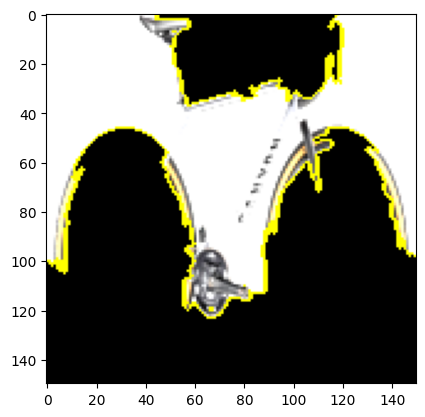

In [55]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
img_boundry1 = mark_boundaries(temp/150, mask)
plt.imshow(img_boundry1)

This is very interesting...I have noticed that many gravel bikes are now following the latest trend in using gumwall, vintage tires...the classifier picked it up!

Let's try now with a Mountain Bike..

In [56]:
path=data_dir + '/mountain_bikes/mountain_bike_44.jpg'
path

'/content/drive/MyDrive/data (1)/train//mountain_bikes/mountain_bike_44.jpg'

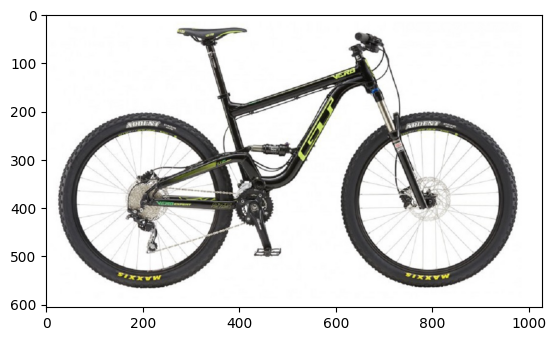

In [57]:
img = get_image(path)
plt.imshow(img)

In [58]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

1

In [59]:
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=100) # number of images that will be sent to classification function

  0%|          | 0/100 [00:00<?, ?it/s]

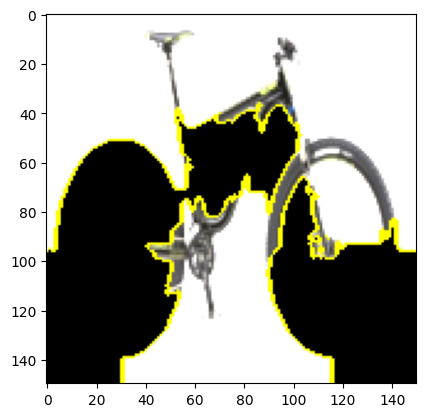

In [60]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
img_boundry1 = mark_boundaries(temp/150, mask)
plt.imshow(img_boundry1)

Again..super interesting! the classifier noticed that often Mountain Bikes have irregular junctions between seat and down tube to allow rear suspension mount points....very impressive

Now lets try with a road bike...I am curious..

In [61]:
path=data_dir + '/road_bikes/road_bike_81.jpg'
path

'/content/drive/MyDrive/data (1)/train//road_bikes/road_bike_81.jpg'

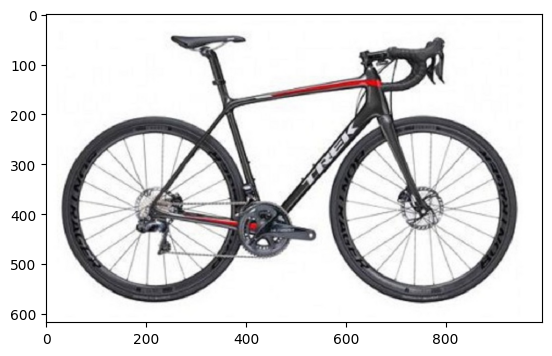

In [62]:
img = get_image(path)
plt.imshow(img)

In [63]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

2

In [64]:
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=3, 
                                         hide_color=0, 
                                         num_samples=100) # number of images that will be sent to classification function

  0%|          | 0/100 [00:00<?, ?it/s]

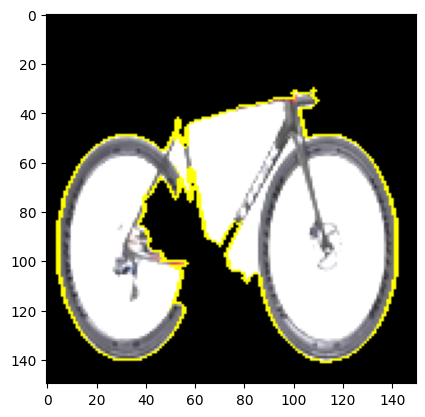

In [65]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
img_boundry1 = mark_boundaries(temp/150, mask)
plt.imshow(img_boundry1)

I should have thought about it! often road bikes are equipped with aerodynamic deep dish wheelset and the classifier picked it up...